In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py
from plotly.subplots import make_subplots
import plotly.io as pio
import warnings
warnings.filterwarnings('ignore')
pio.renderers
from pandas_datareader import data as web 

from datetime import datetime as dt
from datetime import timedelta


from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from pmdarima.arima import auto_arima, ADFTest

In [158]:
covid = pd.read_csv('covid_19_data_latest.csv')
covid.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.00000,0.00000,0.00000
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.00000,0.00000,0.00000
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.00000,0.00000,0.00000
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.00000,0.00000,0.00000
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.00000,0.00000,0.00000


## More info on the variables

In [159]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156292 entries, 0 to 156291
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   SNo              156292 non-null  int64  
 1   ObservationDate  156292 non-null  object 
 2   Province/State   111976 non-null  object 
 3   Country/Region   156292 non-null  object 
 4   Last Update      156292 non-null  object 
 5   Confirmed        156292 non-null  float64
 6   Deaths           156292 non-null  float64
 7   Recovered        156292 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 9.5+ MB


In [160]:
covid.describe()


,SNo,Confirmed,Deaths,Recovered
count,156292.00000,156292.00000,156292.00000,156292.00000
mean,78146.50000,28443.39863,966.09027,17932.31956
std,45117.75847,88098.00367,3278.11068,98130.18458
min,1.00000,-302844.00000,-178.00000,-854405.00000
25%,39073.75000,390.00000,5.00000,10.00000
50%,78146.50000,3410.00000,67.00000,757.00000
75%,117219.25000,15978.75000,486.00000,6270.00000
max,156292.00000,1867721.00000,45974.00000,4174884.00000


### Preprocessing the data

In [161]:
covid = covid.drop(['SNo', 'Last Update'], axis =1)
covid = covid.rename(columns={'ObservationDate':'Date','Province/State':'State','Country/Region':'Country'})
covid.head()


,Date,State,Country,Confirmed,Deaths,Recovered
0,01/22/2020,Anhui,Mainland China,1.00000,0.00000,0.00000
1,01/22/2020,Beijing,Mainland China,14.00000,0.00000,0.00000
2,01/22/2020,Chongqing,Mainland China,6.00000,0.00000,0.00000
3,01/22/2020,Fujian,Mainland China,1.00000,0.00000,0.00000
4,01/22/2020,Gansu,Mainland China,0.00000,0.00000,0.00000


In [162]:
confirmed= covid.loc[covid['Date'] == '11/15/2020']
confirmed = confirmed.groupby(['Country']).sum()[['Confirmed','Recovered','Deaths']].sort_values(by=['Confirmed'], ascending=False)
confirmed.head()


,Confirmed,Recovered,Deaths
Country,,,
US,11036935.00000,4174884.00000,246214.00000
India,8845127.00000,8249579.00000,130070.00000
Brazil,5863093.00000,5279452.00000,165798.00000
France,1915713.00000,139760.00000,42601.00000
Russia,1910149.00000,1429565.00000,32885.00000


In [163]:
covid.Date = pd.to_datetime(covid.Date.astype(str), dayfirst=False, errors='coerce')
covid.Date.tail()

156287   2020-11-15
156288   2020-11-15
156289   2020-11-15
156290   2020-11-15
156291   2020-11-15
Name: Date, dtype: datetime64[ns]

In [164]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156292 entries, 0 to 156291
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date       156292 non-null  datetime64[ns]
 1   State      111976 non-null  object        
 2   Country    156292 non-null  object        
 3   Confirmed  156292 non-null  float64       
 4   Deaths     156292 non-null  float64       
 5   Recovered  156292 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 7.2+ MB


## EDA And visualization

In [165]:
#Combining all the confirmed cases, in a day period

cumulative_confirmed = covid.groupby('Date').Confirmed.sum()
cumulative_confirmed = cumulative_confirmed.groupby(cumulative_confirmed.index.to_period('y')).cumsum().reset_index()
for i in range(298,0,-1):
    cumulative_confirmed['Confirmed'].iloc[i] = cumulative_confirmed['Confirmed'].iloc[i]-cumulative_confirmed['Confirmed'].iloc[i-1]
cumulative_confirmed.head()

,Date,Confirmed
0,2020-01-22,555.00000
1,2020-01-23,653.00000
2,2020-01-24,941.00000
3,2020-01-25,1438.00000
4,2020-01-26,2118.00000


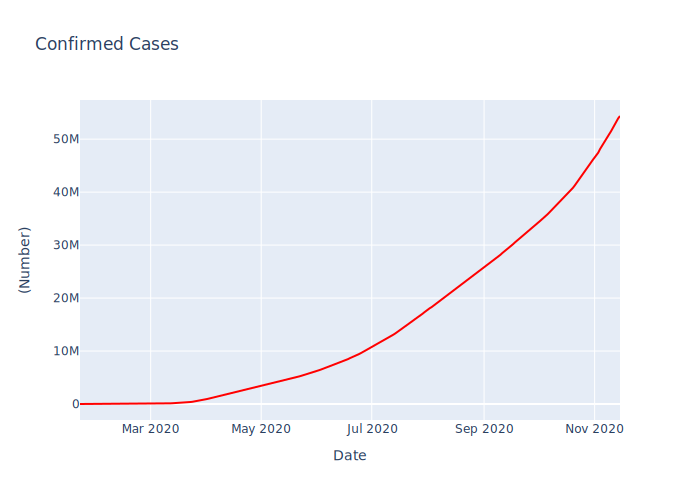

In [166]:
#Plotting a graph for the cumulative confirmed cases

confirmed_graph = go.Scatter(x=cumulative_confirmed.Date,y=cumulative_confirmed.Confirmed, marker=dict(color='red'))
layout = go.Layout(title='Confirmed Cases', xaxis=dict(title='Date'), yaxis=dict(title='(Number)'))
fig = go.Figure(data=[confirmed_graph], layout=layout)
fig.update_layout()
fig.show("svg")

## Recovered Cases !

In [167]:
cumulative_recovered = covid.groupby('Date').Recovered.sum()
cumulative_recovered = cumulative_recovered.groupby(cumulative_recovered.index.to_period('y')).cumsum().reset_index()
for i in range(298,0,-1):
    cumulative_recovered['Recovered'].iloc[i] = cumulative_recovered['Recovered'].iloc[i]-cumulative_recovered['Recovered'].iloc[i-1]
cumulative_recovered.tail(10)

,Date,Recovered
289,2020-11-06,32480626.00000
290,2020-11-07,32779541.00000
291,2020-11-08,33032762.00000
292,2020-11-09,33289404.00000
293,2020-11-10,33544236.00000
294,2020-11-11,33926351.00000
295,2020-11-12,34149223.00000
296,2020-11-13,34450332.00000
297,2020-11-14,34726418.00000
298,2020-11-15,34955148.00000


## Plotting them !

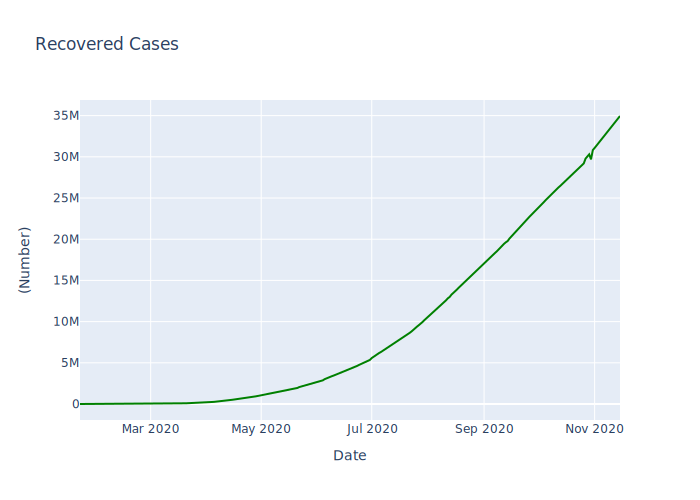

In [168]:
recovered_graph = go.Scatter(x=cumulative_recovered.Date,y=cumulative_recovered.Recovered, marker=dict(color='green'))
layout = go.Layout(title='Recovered Cases', xaxis=dict(title='Date'), yaxis=dict(title='(Number)'))
fig = go.Figure(data=[recovered_graph], layout=layout)
fig.update_layout()
fig.show(renderer="svg")

### Cumulating all the deaths
- and then plotting it !

In [169]:
cumulative_deaths = covid.groupby('Date').Deaths.sum()
cumulative_deaths = cumulative_deaths.groupby(cumulative_deaths.index.to_period('y')).cumsum().reset_index()
for i in range(298,0,-1):
    cumulative_deaths['Deaths'].iloc[i] = cumulative_deaths['Deaths'].iloc[i]-cumulative_deaths['Deaths'].iloc[i-1]
cumulative_deaths.head(10)

,Date,Deaths
0,2020-01-22,17.00000
1,2020-01-23,18.00000
2,2020-01-24,26.00000
3,2020-01-25,42.00000
4,2020-01-26,56.00000
5,2020-01-27,82.00000
6,2020-01-28,131.00000
7,2020-01-29,133.00000
8,2020-01-30,171.00000
9,2020-01-31,213.00000


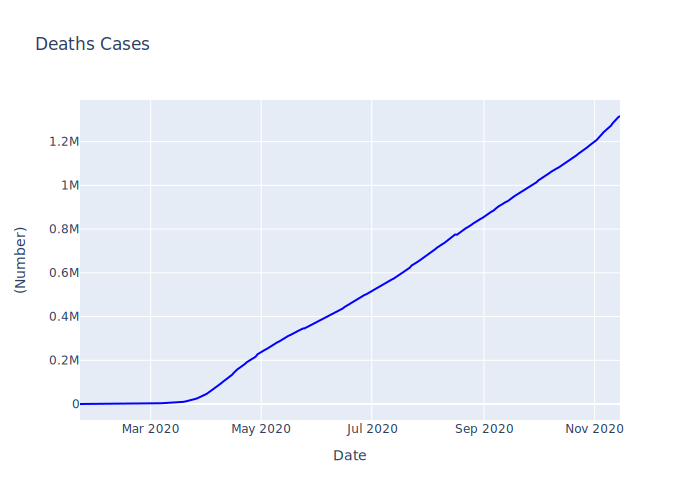

In [170]:
death_graph = go.Scatter(x=cumulative_deaths.Date,y=cumulative_deaths.Deaths, marker=dict(color='blue'))
layout = go.Layout(title='Deaths Cases', xaxis=dict(title='Date'), yaxis=dict(title='(Number)'))
fig = go.Figure(data=[death_graph], layout=layout)
fig.update_layout()
fig.show(renderer="svg")

### Concatenate all three dataframes, by date

In [171]:
cumulative_final=pd.concat([cumulative_recovered,cumulative_confirmed.drop(['Date'],axis =1),cumulative_deaths.drop(['Date'],axis =1)],axis=1,sort=False)
cumulative_final.head(10)

,Date,Recovered,Confirmed,Deaths
0,2020-01-22,28.00000,555.00000,17.00000
1,2020-01-23,30.00000,653.00000,18.00000
2,2020-01-24,36.00000,941.00000,26.00000
3,2020-01-25,39.00000,1438.00000,42.00000
4,2020-01-26,52.00000,2118.00000,56.00000
5,2020-01-27,61.00000,2927.00000,82.00000
6,2020-01-28,107.00000,5578.00000,131.00000
7,2020-01-29,126.00000,6165.00000,133.00000
8,2020-01-30,143.00000,8235.00000,171.00000
9,2020-01-31,222.00000,9925.00000,213.00000


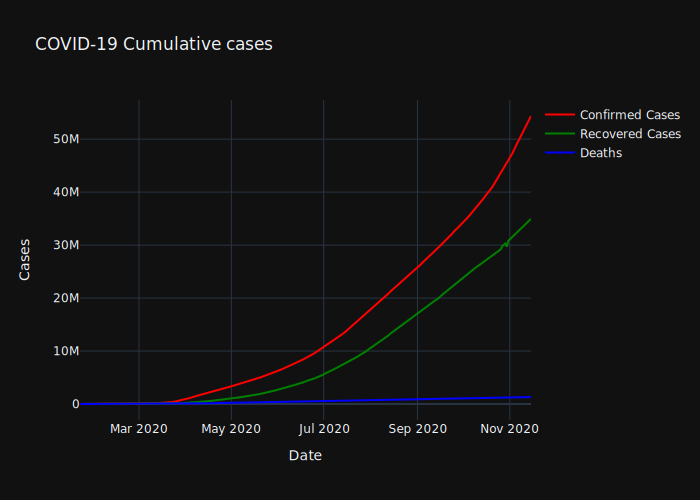

In [172]:
trace_Confirmed = go.Scatter(x=cumulative_final.Date,
                  y=cumulative_final.Confirmed,
                  name='Confirmed Cases',
                  marker=dict(color='red'))

trace_Recovered = go.Scatter(x=cumulative_final.Date,
                y=cumulative_final.Recovered,
                name='Recovered Cases',
                marker=dict(color='green'))

trace_Deaths = go.Scatter(x=cumulative_final.Date,
                y=cumulative_final.Deaths,
                name='Deaths',
                marker=dict(color='blue'))

data = [trace_Confirmed, trace_Recovered, trace_Deaths]

layout = go.Layout(title="COVID-19 Cumulative cases",
                xaxis=dict(title='Date'),
                yaxis=dict(title='Cases'))

fig = go.Figure(data=data, layout=layout)
fig.update_layout(template='plotly_dark')
fig.show(renderer="svg")

In [173]:
per_day_cases = cumulative_final.copy()
for i in range(298,0,-1):
    per_day_cases['Deaths'].iloc[i] = per_day_cases['Deaths'].iloc[i]-per_day_cases['Deaths'].iloc[i-1]
    per_day_cases['Confirmed'].iloc[i] = per_day_cases['Confirmed'].iloc[i]-per_day_cases['Confirmed'].iloc[i-1]
    per_day_cases['Recovered'].iloc[i] = per_day_cases['Recovered'].iloc[i]-per_day_cases['Recovered'].iloc[i-1]
per_day_cases.head(10)



,Date,Recovered,Confirmed,Deaths
0,2020-01-22,28.00000,555.00000,17.00000
1,2020-01-23,2.00000,98.00000,1.00000
2,2020-01-24,6.00000,288.00000,8.00000
3,2020-01-25,3.00000,497.00000,16.00000
4,2020-01-26,13.00000,680.00000,14.00000
5,2020-01-27,9.00000,809.00000,26.00000
6,2020-01-28,46.00000,2651.00000,49.00000
7,2020-01-29,19.00000,587.00000,2.00000
8,2020-01-30,17.00000,2070.00000,38.00000
9,2020-01-31,79.00000,1690.00000,42.00000


### Plotting the graph for cases that are recorded every day


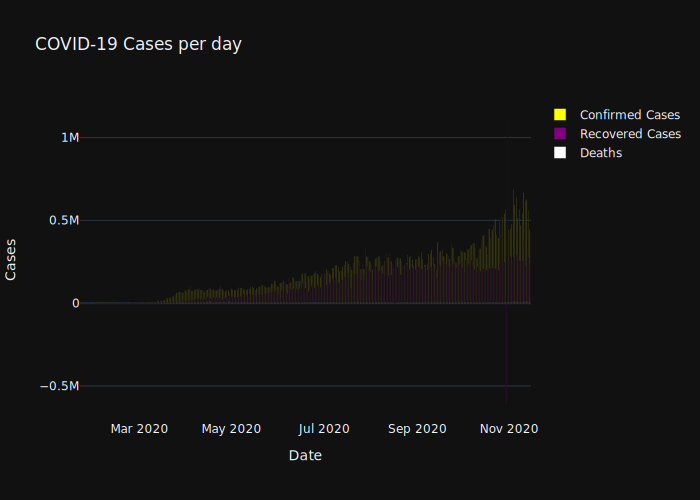

In [174]:
trace_Confirmed = go.Bar(x=per_day_cases.Date,
                         y = per_day_cases.Confirmed,
                         name = 'Confirmed Cases',
                         marker = dict(color = 'yellow'))

trace_Recovered = go.Bar(x=per_day_cases.Date,
                         y = per_day_cases.Recovered,
                         name = 'Recovered Cases',
                         marker = dict(color = 'purple'))

trace_Deaths = go.Bar(x=per_day_cases.Date,
                         y = per_day_cases.Deaths,
                         name = 'Deaths',
                         marker = dict(color = 'white'))

data = [trace_Confirmed, trace_Recovered, trace_Deaths]


layout = go.Layout(title = 'COVID-19 Cases per day',
                   xaxis = dict(title='Date'),
                   yaxis = dict(title='Cases'))


fig = go.Figure(data = data, layout = layout)
fig.update_layout(template='plotly_dark')

fig.show(renderer='svg')

### Finding the Mortality and the Recovery Rate


In [175]:
confirmed['Mortality_rate'] =( confirmed['Deaths']/confirmed['Confirmed']*100)
confirmed['Recovery_rate'] =( confirmed['Recovered']/confirmed['Confirmed']*100) 
confirmed.head(10) 


,Confirmed,Recovered,Deaths,Mortality_rate,Recovery_rate
Country,,,,,
US,11036935.00000,4174884.00000,246214.00000,2.23082,37.82648
India,8845127.00000,8249579.00000,130070.00000,1.47053,93.26694
Brazil,5863093.00000,5279452.00000,165798.00000,2.82782,90.04551
France,1915713.00000,139760.00000,42601.00000,2.22377,7.29546
Russia,1910149.00000,1429565.00000,32885.00000,1.72159,74.84050
Spain,1458591.00000,150376.00000,40769.00000,2.79509,10.30968
UK,1372884.00000,3121.00000,52026.00000,3.78954,0.22733
Argentina,1310491.00000,1129102.00000,35436.00000,2.70402,86.15870
Colombia,1198746.00000,1104956.00000,34031.00000,2.83888,92.17599


## Computing the active cases Worldwide

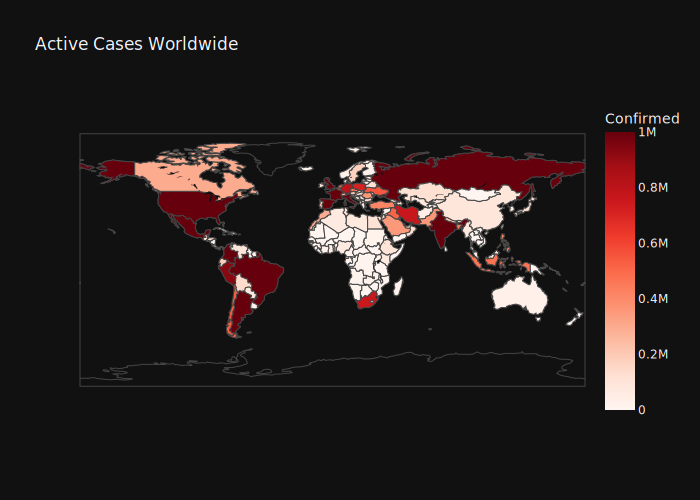

In [176]:
worldplot = confirmed.reset_index()
fig = px.choropleth(worldplot, locations='Country',
                    locationmode='country names', color = 'Confirmed',
                    hover_name = 'Country', range_color = [1,1000000],
                    color_continuous_scale = 'Reds',
                    title = 'Active Cases Worldwide')

fig.update_layout(template ='plotly_dark')
fig.show(renderer = 'svg')

In [177]:
worldplot[["Country","Confirmed","Recovered","Deaths","Mortality_rate","Recovery_rate"]].head().sort_values(["Confirmed"],ascending=False).style.background_gradient(cmap="Reds")


,Country,Confirmed,Recovered,Deaths,Mortality_rate,Recovery_rate
0,US,11036935.000000,4174884.000000,246214.000000,2.230819,37.826480
1,India,8845127.000000,8249579.000000,130070.000000,1.470527,93.266937
2,Brazil,5863093.000000,5279452.000000,165798.000000,2.827825,90.045510
3,France,1915713.000000,139760.000000,42601.000000,2.223767,7.295456
4,Russia,1910149.000000,1429565.000000,32885.000000,1.721593,74.840497


## Plotting Mortality vs. Recovery Rate

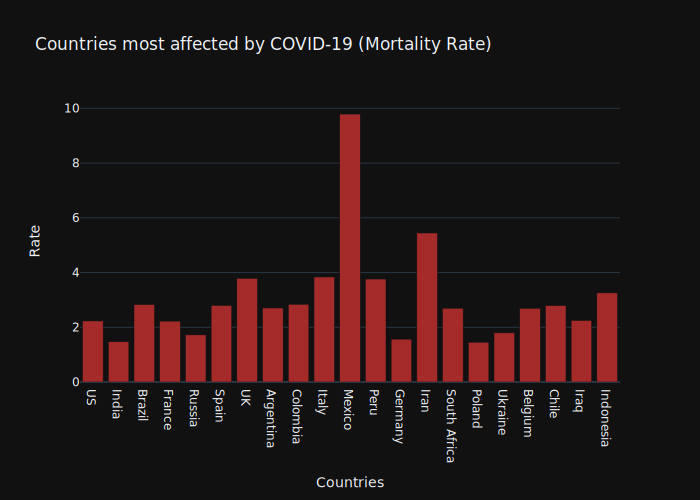

In [178]:
countries = confirmed.iloc[0:21]
countries = countries.reset_index()

trace_mortality_rate = go.Bar(x=countries.Country,
                              y = countries. Mortality_rate,
                              name = 'Mortality Rate',
                              marker = dict(color='brown'))


data = [ trace_mortality_rate]

layout = go.Layout(title = 'Countries most affected by COVID-19 (Mortality Rate)',
                   xaxis = dict(title='Countries'),
                   yaxis = dict(title='Rate'))


fig = go.Figure(data = data, layout = layout)
fig.update_layout(template = 'plotly_dark')


fig.show(renderer='svg')


In [179]:
# Highest mortality Rate

mortality = confirmed.sort_values(by=['Mortality_rate'], ascending=False)
mortality.head()

,Confirmed,Recovered,Deaths,Mortality_rate,Recovery_rate
Country,,,,,
Yemen,2072.00000,1394.00000,605.00000,29.19884,67.27799
MS Zaandam,9.00000,0.00000,2.00000,22.22222,0.00000
Western Sahara,10.00000,8.00000,1.00000,10.00000,80.00000
Mexico,1006522.00000,750190.00000,98542.00000,9.79035,74.53290
Sudan,14626.00000,9571.00000,1116.00000,7.63025,65.43826


In [180]:
# Highest recovery Rate

recovery=confirmed.sort_values(by=['Recovery_rate'], ascending=False)
recovery.head()

,Confirmed,Recovered,Deaths,Mortality_rate,Recovery_rate
Country,,,,,
Marshall Islands,1.00000,1.00000,0.00000,0.00000,100.00000
Saint Kitts and Nevis,19.00000,19.00000,0.00000,0.00000,100.00000
Timor-Leste,30.00000,30.00000,0.00000,0.00000,100.00000
Macau,46.00000,46.00000,0.00000,0.00000,100.00000
Singapore,58119.00000,58029.00000,28.00000,0.04818,99.84515


## Plotting the top 15 countries with the highest mortality and recovery rates

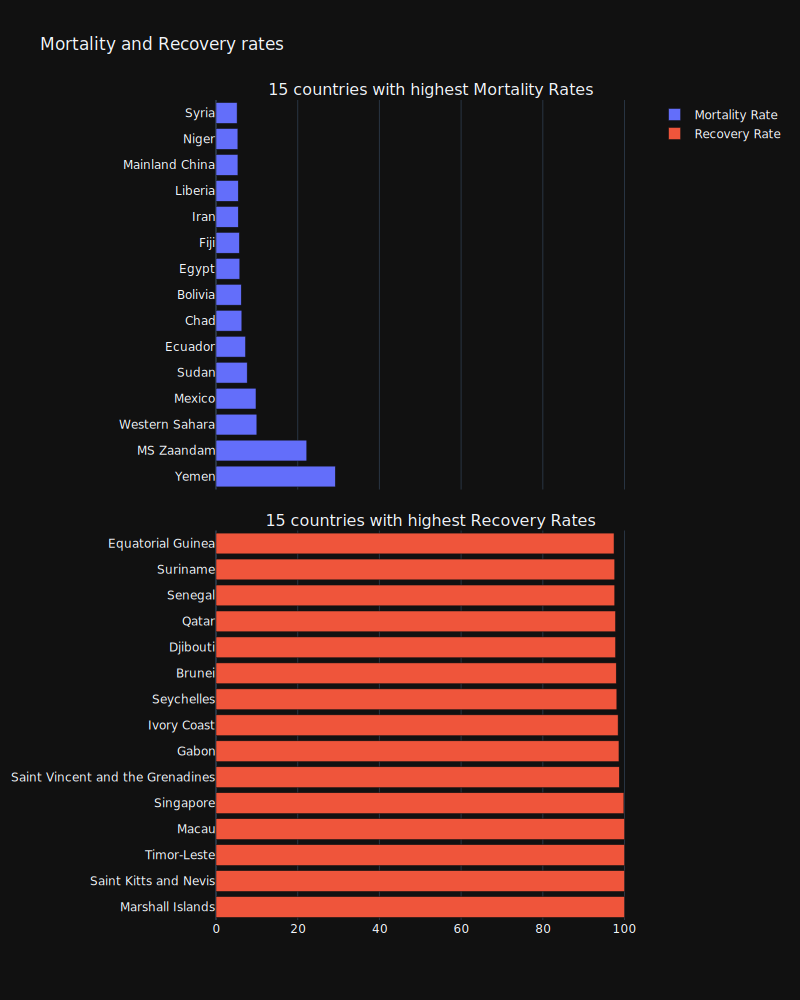

In [181]:
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=("15 countries with highest Mortality Rates","15 countries with highest Recovery Rates"),
    shared_xaxes=True,
    shared_yaxes=False,
    vertical_spacing=0.05)

top_15_mortality=mortality.sort_values(["Mortality_rate"],ascending=False).head(15)
top_15_recovery=recovery.sort_values(["Recovery_rate"],ascending=False).head(15)

fig.append_trace(go.Bar(
    x=top_15_mortality["Mortality_rate"],
    y=top_15_mortality.index,
    orientation ='h',
    #marker=dict(color='blue'),
    name="Mortality Rate"
), row=1, col=1)

fig.append_trace(go.Bar(
    x=top_15_recovery["Recovery_rate"],
    y=top_15_recovery.index,
    orientation ='h',
    name="Recovery Rate"
), row=2, col=1)
fig.update_layout(height=1000, width=800, title_text="Mortality and Recovery rates")
fig.update_layout(template='plotly_dark')
fig.show(renderer="svg")

In [182]:
pd.set_option('display.float_format', lambda x : '%.5f' % x)

In [183]:
cumulative_confirmed.set_index('Date', inplace=True)

In [184]:
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(cumulative_confirmed)

(0.99, True)

In [185]:
# Converting 'Observation Date' into a Datetime format
covid = covid.rename(columns={'Date': 'ObservationDate'})
covid = covid.rename(columns={'Country':'Country/Region'})
covid['ObservationDate'] = pd.to_datetime(covid['ObservationDate'])

In [186]:
## Grouping the data by order of Country

country_wise = covid.groupby(["Country/Region","ObservationDate"]).agg({"Confirmed":'sum', "Recovered":'sum', "Deaths":'sum'})
country_wise

Confirmed  Recovered  Deaths
Country/Region                 ObservationDate                              
 Azerbaijan                    2020-02-28         1.00000    0.00000 0.00000
('St. Martin',)                2020-03-10         2.00000    0.00000 0.00000
Afghanistan                    2020-02-24         1.00000    0.00000 0.00000
                               2020-02-25         1.00000    0.00000 0.00000
                               2020-02-26         1.00000    0.00000 0.00000
...                                                   ...        ...     ...
occupied Palestinian territory 2020-03-12         0.00000    0.00000 0.00000
                               2020-03-14         0.00000    0.00000 0.00000
                               2020-03-15         0.00000    0.00000 0.00000
                               2020-03-16         0.00000    0.00000 0.00000
                               2020-03-17         0.00000    0.00000 0.00000

[48961 rows x 3 columns]

In [187]:
#Calculating active cases

country_wise["Active Cases"] = country_wise["Confirmed"] - country_wise["Recovered"] - country_wise["Deaths"]
country_wise["log_confirmed"] = np.log(country_wise["Confirmed"])
country_wise["log_active"] = np.log(country_wise["Active Cases"])


## Analyzing Datewise

In [188]:
date_wise = covid.groupby(["ObservationDate"]).agg({"Confirmed":'sum', "Recovered":'sum', "Deaths":'sum'})
date_wise['Days Since'] = date_wise.index - date_wise.index.min()


In [189]:
date_wise.head()

,Confirmed,Recovered,Deaths,Days Since
ObservationDate,,,,
2020-01-22,555.00000,28.00000,17.00000,0 days
2020-01-23,653.00000,30.00000,18.00000,1 days
2020-01-24,941.00000,36.00000,26.00000,2 days
2020-01-25,1438.00000,39.00000,42.00000,3 days
2020-01-26,2118.00000,52.00000,56.00000,4 days


In [190]:
print("Basic Information")
print("Totol number of countries with Disease Spread: ", len(covid["Country/Region"].unique()))
print("Total number of Confirmed Cases around the World: ", date_wise["Confirmed"].iloc[-1])
print("Total number of Recovered Cases around the World: ", date_wise["Recovered"].iloc[-1])
print("Total number of Deaths Cases around the World: ", date_wise["Deaths"].iloc[-1])
print("Total number of Active Cases around the World: ", (date_wise["Confirmed"].iloc[-1] - date_wise["Recovered"].iloc[-1] - date_wise["Deaths"].iloc[-1]))
print("Total number of Closed Cases around the World: ", date_wise["Recovered"].iloc[-1] + date_wise["Deaths"].iloc[-1])
print("Approximate number of Confirmed Cases per Day around the World: ", np.round(date_wise["Confirmed"].iloc[-1]/ date_wise.shape[0]))
print("Approximate number of Recovered Cases per Day around the World: ", np.round(date_wise["Recovered"].iloc[-1]/ date_wise.shape[0]))
print("Approximate number of Death Cases per Day around the World: ", np.round(date_wise["Deaths"].iloc[-1]/ date_wise.shape[0]))
print("Approximate number of Confirmed Cases per hour around the World: ", np.round(date_wise["Confirmed"].iloc[-1]/ ((date_wise.shape[0])*24)))
print("Approximate number of Recovered Cases per hour around the World: ", np.round(date_wise["Recovered"].iloc[-1]/ ((date_wise.shape[0])*24)))
print("Approximate number of Death Cases per hour around the World: ", np.round(date_wise["Deaths"].iloc[-1]/ ((date_wise.shape[0])*24)))
print("Number of Confirmed Cases in last 24 hours: ", date_wise["Confirmed"].iloc[-1] - date_wise["Confirmed"].iloc[-2])
print("Number of Recovered Cases in last 24 hours: ", date_wise["Recovered"].iloc[-1] - date_wise["Recovered"].iloc[-2])
print("Number of Death Cases in last 24 hours: ", date_wise["Deaths"].iloc[-1] - date_wise["Deaths"].iloc[-2])

Basic Information
Totol number of countries with Disease Spread:  226
Total number of Confirmed Cases around the World:  54370186.0
Total number of Recovered Cases around the World:  34955148.0
Total number of Deaths Cases around the World:  1317139.0
Total number of Active Cases around the World:  18097899.0
Total number of Closed Cases around the World:  36272287.0
Approximate number of Confirmed Cases per Day around the World:  181840.0
Approximate number of Recovered Cases per Day around the World:  116907.0
Approximate number of Death Cases per Day around the World:  4405.0
Approximate number of Confirmed Cases per hour around the World:  7577.0
Approximate number of Recovered Cases per hour around the World:  4871.0
Approximate number of Death Cases per hour around the World:  184.0
Number of Confirmed Cases in last 24 hours:  443028.0
Number of Recovered Cases in last 24 hours:  228730.0
Number of Death Cases in last 24 hours:  5947.0


## Time Series Forecasting

In [191]:
#Splitting the data set (95% test, 5% training)

model_train = date_wise.iloc[:int(date_wise.shape[0] * 0.95)]
model_test = date_wise.iloc[int(date_wise.shape[0] * 0.95):]
y_pred = model_test.copy()
train_data = model_train.copy()

In [192]:
#Utilizing the Holt Linear prediction on the training data

holt = Holt(np.asarray(model_train["Confirmed"])).fit(smoothing_level = 0.4, smoothing_slope = 0.4, optimized = False)     


In [193]:
#Using the Holt Linear model to predict using the test data

model_scores = []
y_pred['Holt'] = holt.forecast(len(model_test))
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"], y_pred["Holt"])))
print('')

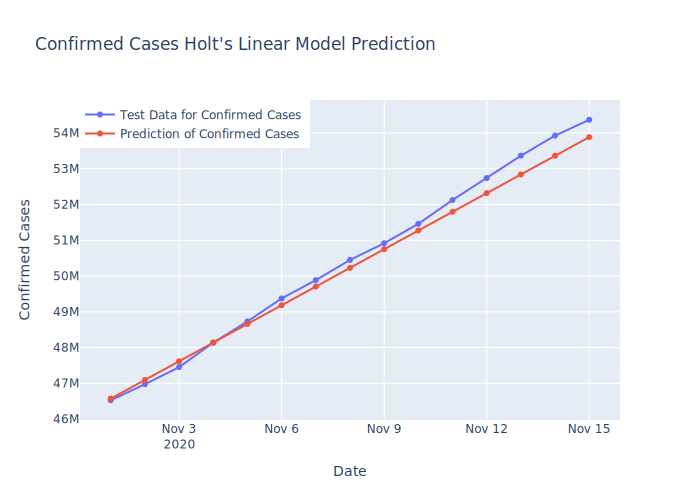

In [194]:
#Testing the model performance on the test data

fig = go.Figure()
fig.add_trace(go.Scatter(x = model_test.index, y = model_test['Confirmed'],
                         mode = 'lines + markers', name = 'Test Data for Confirmed Cases',))
fig.add_trace(go.Scatter(x = model_test.index, y = y_pred['Holt'],
                         mode = 'lines + markers', name = 'Prediction of Confirmed Cases',))
fig.update_layout(title ="Confirmed Cases Holt's Linear Model Prediction",
                  xaxis_title = 'Date', yaxis_title = 'Confirmed Cases', legend = dict(x = 0,y =1, traceorder = 'normal'))
fig.show(renderer='svg')

In [195]:
#Creating a table to compare all the predictions from all the different predictions

holt_new_date = []
holt_new_prediction = []

for i in range(1,18):
    holt_new_date.append(date_wise.index[-1]+timedelta(days=i))
    holt_new_prediction.append(holt.forecast((len(model_test) + i))[-1])
    
    
model_predictions = pd.DataFrame(zip(holt_new_date),
                                 columns = ['Dates'])
    

In [196]:
model_predictions["Holt's Linear Model Predictions"] = holt_new_prediction
model_predictions.head()

,Dates,Holt's Linear Model Predictions
0,2020-11-16,54407104.22421
1,2020-11-17,54929270.75833
2,2020-11-18,55451437.29245
3,2020-11-19,55973603.82658
4,2020-11-20,56495770.36070


## Holt's Winter Model for the Daily Time Series


In [197]:
es = ExponentialSmoothing(np.asarray(model_train['Confirmed']),seasonal_periods = 14, trend = 'add', seasonal = 'mul').fit()

In [198]:
#Root mean squared error for Holt's Winter Model

y_pred["Holt's Winter Model"] = es.forecast(len(model_test))
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"], y_pred["Holt's Winter Model"])))
print("Root Mean Square Error for Holt's Winter Model: ", np.sqrt(mean_squared_error(y_pred["Confirmed"], y_pred["Holt's Winter Model"])))

Root Mean Square Error for Holt's Winter Model:  904299.5228623889


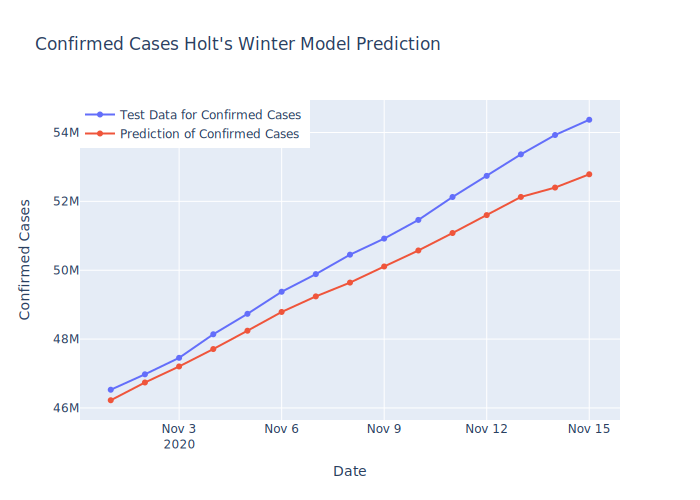

In [199]:
#Obtaining the predictions of the holt winter model using test data

fig = go.Figure()
fig.add_trace(go.Scatter(x = model_test.index, y = model_test["Confirmed"],
                    mode = 'lines + markers', name = "Test Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x = model_test.index, y = y_pred["Holt\'s Winter Model"],
                    mode = 'lines + markers', name = "Prediction of Confirmed Cases",))
fig.update_layout(title = "Confirmed Cases Holt's Winter Model Prediction",
                 xaxis_title = "Date", yaxis_title = "Confirmed Cases", legend = dict(x = 0, y = 1, traceorder = "normal"))
fig.show(renderer="svg")

In [200]:
holt_winter_new_prediction = []
for i in range(1,18):
    holt_winter_new_prediction.append(es.forecast((len(model_test) + i))[-1])
model_predictions["Holt's Winter Model Prediction"] = holt_winter_new_prediction
model_predictions.head()

,Dates,Holt's Linear Model Predictions,Holt's Winter Model Prediction
0,2020-11-16,54407104.22421,53308817.95371
1,2020-11-17,54929270.75833,53774263.78993
2,2020-11-18,55451437.29245,54284292.06775
3,2020-11-19,55973603.82658,54825491.10264
4,2020-11-20,56495770.36070,55380193.25384


## Modelling using AUTO ARIMA (AR Model)

- AR(Auto-Regressive) modelling predicts the future values based on past values

In [201]:
#Training the model

model_ar = auto_arima(model_train['Confirmed'], trace = True, error_action='ignore', start_p = 0, start_q= 0, max_p = 4, max_q = 0,
                      suppress_warnings=True, stepwise=False, seasonal=False)
model_ar.fit(model_train['Confirmed'])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=6609.274, Time=0.06 sec


 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=6589.274, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=6587.251, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=6568.661, Time=0.06 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=6551.178, Time=0.07 sec

Best model:  ARIMA(4,2,0)(0,0,0)[0] intercept
Total fit time: 0.236 seconds


ARIMA(order=(4, 2, 0), scoring_args={}, suppress_warnings=True)

In [202]:
# Predicting using AR

prediction_ar = model_ar.predict(len(model_test))
y_pred['AR Model Prediction'] = prediction_ar

In [203]:
#RMSE for the AR Model

model_scores.append(np.sqrt(mean_squared_error(y_pred['Confirmed'], y_pred['AR Model Prediction'])))
print('Root Mean Squared Error for AR Model: ', np.sqrt(mean_squared_error(y_pred['Confirmed'], y_pred['AR Model Prediction'])))

Root Mean Squared Error for AR Model:  275830.06274960306


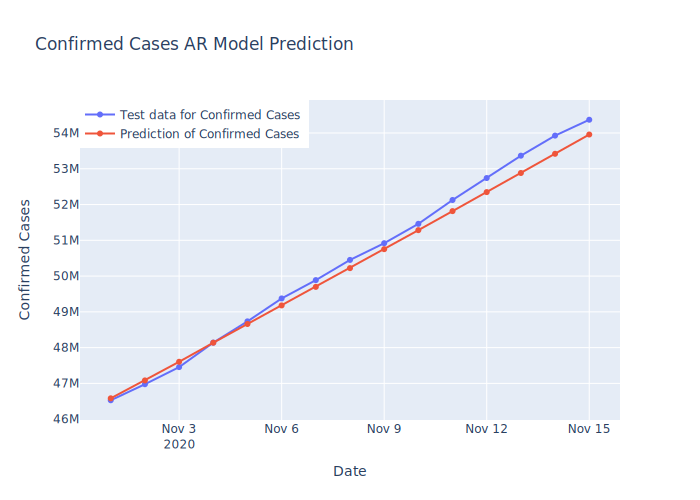

In [204]:
# AR Model Prediction using the test Data

fig = go.Figure()
fig.add_trace(go.Scatter(x = model_test.index, y = model_test['Confirmed'],
                         mode = 'lines + markers', name = 'Test data for Confirmed Cases',))
fig.add_trace(go.Scatter(x = model_test.index, y = y_pred['AR Model Prediction'],
                         mode = 'lines + markers', name = 'Prediction of Confirmed Cases'))
fig.update_layout(title = 'Confirmed Cases AR Model Prediction',
                  xaxis_title = 'Date', yaxis_title = 'Confirmed Cases', legend = dict(x = 0,y=1, traceorder = 'normal'))
fig.show(renderer='svg')

In [205]:
AR_Model_new_prediction = []
for i in range(1,18):
    AR_Model_new_prediction.append(model_ar.predict(len(model_test) + i) [-1])
model_predictions['AR Model Prediction'] = AR_Model_new_prediction
model_predictions.head()



,Dates,Holt's Linear Model Predictions,Holt's Winter Model Prediction,AR Model Prediction
0,2020-11-16,54407104.22421,53308817.95371,54498625.81970
1,2020-11-17,54929270.75833,53774263.78993,55040887.68459
2,2020-11-18,55451437.29245,54284292.06775,55584723.05065
3,2020-11-19,55973603.82658,54825491.10264,56130497.90199
4,2020-11-20,56495770.36070,55380193.25384,56678345.00172


## MA Model (AUTO ARIMA)

- MA(Moving Average) modelling predicts the future values based on the current value and the past forecasted errors

In [206]:
model_ma = auto_arima(model_train["Confirmed"], trace = True, error_action = 'ignore', start_p = 0, start_q = 0, max_p = 0, max_q = 2,
                   suppress_warnings = True, stepwise = False, seasonal = False)
model_ma.fit(model_train["Confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=6609.274, Time=0.02 sec


 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=6564.871, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=6583.289, Time=0.05 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0] intercept
Total fit time: 0.116 seconds


ARIMA(order=(0, 2, 1), scoring_args={}, suppress_warnings=True)

In [207]:
#Get the predictions for the ARIMA Model

prediction_ma = model_ma.predict(len(model_test))
y_pred["MA Model Prediction"] = prediction_ma

In [208]:
#RMSE for MA Modelmodel_scores.append(np.sqrt(mean_squared_error(model_test["Confirmed"], prediction_ma)))
print("Root Mean Square Error for MA Model: ", np.sqrt(mean_squared_error(model_test["Confirmed"], prediction_ma)))

Root Mean Square Error for MA Model:  205750.14791304883


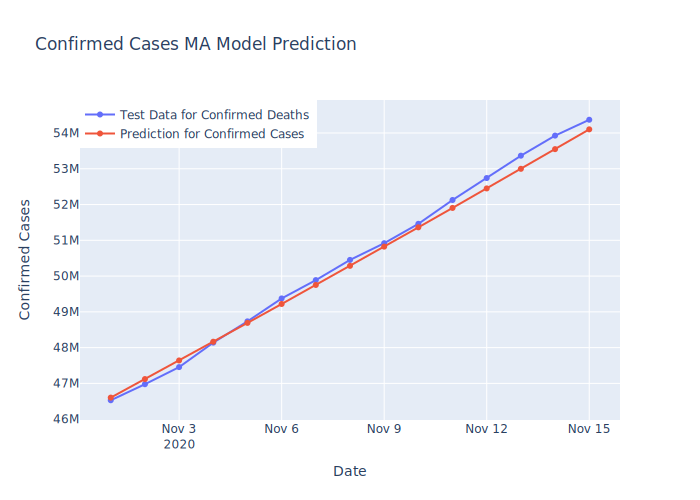

In [209]:
#Test Data Evaluation using ARIMA

fig = go.Figure()
fig.add_trace(go.Scatter(x=model_test.index, y= model_test['Confirmed'],
                                   mode = 'lines + markers', name = 'Test Data for Confirmed Deaths',))
fig.add_trace(go.Scatter(x=model_test.index, y = y_pred['MA Model Prediction'],
                         mode = 'lines + markers', name = 'Prediction for Confirmed Cases',))
fig.update_layout(title = 'Confirmed Cases MA Model Prediction',
                  xaxis_title = 'Date', yaxis_title = 'Confirmed Cases', legend = dict(x=0,y=1,traceorder = 'normal'))
fig.show(renderer='svg')



In [210]:
MA_Model_new_prediction = []
for i in range(1,18):
    MA_Model_new_prediction.append(model_ma.predict(len(model_test) + i )[-1])
model_predictions['MA Model Prediction'] = MA_Model_new_prediction
model_predictions.head()


,Dates,Holt's Linear Model Predictions,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction
0,2020-11-16,54407104.22421,53308817.95371,54498625.81970,54657721.98894
1,2020-11-17,54929270.75833,53774263.78993,55040887.68459,55216316.54314
2,2020-11-18,55451437.29245,54284292.06775,55584723.05065,55777608.87585
3,2020-11-19,55973603.82658,54825491.10264,56130497.90199,56341598.98708
4,2020-11-20,56495770.36070,55380193.25384,56678345.00172,56908286.87682


## ARIMA Model

In [211]:

model_arima = auto_arima(model_train['Confirmed'], trace=True, error_action='ignore',start_p=1, start_q=1, max_p=3,max_q =3,
                        suppress_warnings=True,stepwise=False,seasonal=False )
model_arima.fit(model_train['Confirmed'])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=6609.274, Time=0.01 sec


 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=6564.871, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=6583.289, Time=0.05 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=6598.046, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=6589.274, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=6561.739, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=6682.732, Time=0.10 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=6587.251, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=6559.129, Time=0.08 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=6568.661, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=6530.336, Time=0.08 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=6606.357, Time=0.10 sec

Best model:  ARIMA(3,2,1)(0,0,0)[0] intercept
Total fit time: 1.625 seconds


ARIMA(order=(3, 2, 1), scoring_args={}, suppress_warnings=True)

In [212]:
prediction_arima = model_arima.predict(len(model_test))
y_pred['ARIMA Model Prediction'] = prediction_arima

In [213]:
# Finding out the RMSE for the ARIMA Model

model_scores.append(np.sqrt(mean_squared_error(model_test['Confirmed'], prediction_arima)))
print("Root Mean Square Value for the ARIMA model: ", np.sqrt(mean_squared_error(model_test['Confirmed'], prediction_arima)) )

Root Mean Square Value for the ARIMA model:  291923.79807812045


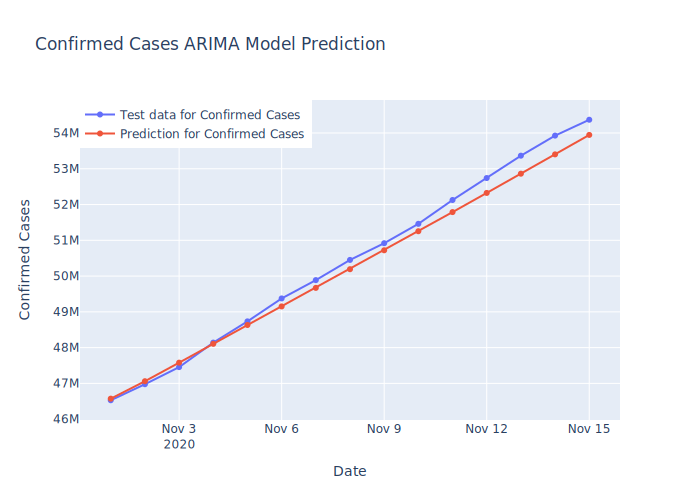

In [214]:
#Comparing the performace on the Test data

fig = go.Figure()
fig.add_trace(go.Scatter(x = model_test.index, y = model_test["Confirmed"],
                    mode = 'lines + markers', name = "Test data for Confirmed Cases",))
fig.add_trace(go.Scatter(x = model_test.index, y = y_pred["ARIMA Model Prediction"],
                    mode = 'lines + markers', name = "Prediction for Confirmed Cases",))
fig.update_layout(title = "Confirmed Cases ARIMA Model Prediction",
                 xaxis_title = "Date", yaxis_title = "Confirmed Cases",legend = dict(x = 0, y = 1, traceorder = "normal"))
fig.show(renderer="svg")

In [215]:
ARIMA_model_new_prediction = []
for i in range(1,18):
    ARIMA_model_new_prediction.append(model_arima.predict(len(model_test) + i)[-1])
model_predictions['ARIMA Model Prediction'] = ARIMA_model_new_prediction
model_predictions.head()

,Dates,Holt's Linear Model Predictions,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction
0,2020-11-16,54407104.22421,53308817.95371,54498625.81970,54657721.98894,54492427.45589
1,2020-11-17,54929270.75833,53774263.78993,55040887.68459,55216316.54314,55041294.94152
2,2020-11-18,55451437.29245,54284292.06775,55584723.05065,55777608.87585,55592427.23728
3,2020-11-19,55973603.82658,54825491.10264,56130497.90199,56341598.98708,56145970.09916
4,2020-11-20,56495770.36070,55380193.25384,56678345.00172,56908286.87682,56702104.09916


## SARIMA Modelling (Also using AutoARIMA)

In [216]:
model_sarima = auto_arima(model_train['Confirmed'], trace=True, error_action='ignore',
                          start_p=0, start_q=0,max_p=2,max_q=2, m=7,
                          suppress_warnings=True, stepwise=True,seasonal=True)
model_arima.fit(model_train['Confirmed'])

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=6522.508, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=6608.241, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=6499.469, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=6511.891, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[7]             : AIC=6589.078, Time=0.01 sec
 ARIMA(1,2,0)(2,0,0)[7]             : AIC=6471.770, Time=0.14 sec
 ARIMA(1,2,0)(2,0,1)[7]             : AIC=6408.809, Time=0.68 sec
 ARIMA(1,2,0)(1,0,1)[7]             : AIC=6462.800, Time=0.14 sec
 ARIMA(1,2,0)(2,0,2)[7]             : AIC=6464.900, Time=0.29 sec
 ARIMA(1,2,0)(1,0,2)[7]             : AIC=6462.928, Time=0.24 sec
 ARIMA(0,2,0)(2,0,1)[7]             : AIC=6520.747, Time=0.13 sec
 ARIMA(2,2,0)(2,0,1)[7]             : AIC=6449.923, Time=0.26 sec
 ARIMA(1,2,1)(2,0,1)[7]             : AIC=6436.874, Time=0.26 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=6442.011, Time=0.17 sec
 ARIMA(2,2,1)(2,0,1)[7]          

ARIMA(order=(3, 2, 1), scoring_args={}, suppress_warnings=True)

In [217]:
#Getting the predictions from the SARIMA Model

prediction_sarima = model_sarima.predict(len(model_test))
y_pred['SARIMA Model Prediction'] = prediction_sarima

In [224]:
#Root mean square error for the SARIMA MODEL

model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"], y_pred["SARIMA Model Prediction"])))
print("Root Mean Square Error for SARIMA Model: ", np.sqrt(mean_squared_error(y_pred["Confirmed"], y_pred["SARIMA Model Prediction"])))

Root Mean Square Error for SARIMA Model:  132447.06658468334


[299443.1366178012,
 904299.5228623889,
 275830.06274960306,
 291923.79807812045,
 132447.06658468334,
 132447.06658468334]

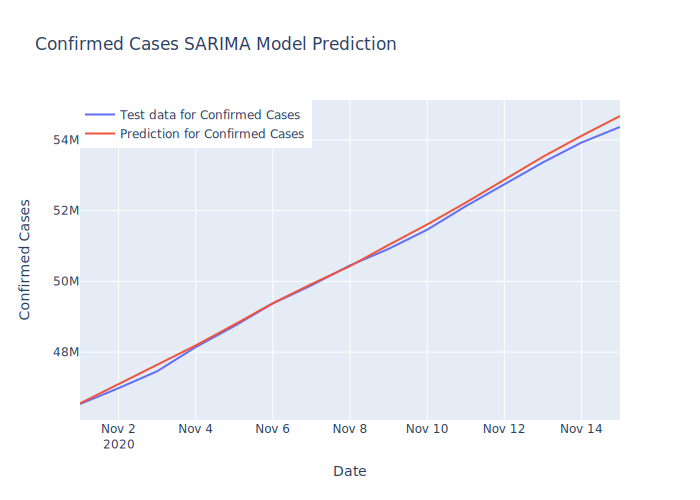

In [219]:
#Mapping the model test data

fig = go.Figure()

fig.add_trace(go.Scatter(x=model_test.index, y=model_test['Confirmed'],
                         mode = 'lines', name = 'Test data for Confirmed Cases'))
fig.add_trace(go.Scatter(x=model_test.index, y=y_pred['SARIMA Model Prediction'],
                         mode = 'lines', name = 'Prediction for Confirmed Cases',))
fig.update_layout(title = 'Confirmed Cases SARIMA Model Prediction',
                  xaxis_title='Date', yaxis_title='Confirmed Cases',legend =dict(x=0,y=1,traceorder = 'normal'))
fig.show(renderer='svg')

In [220]:
SARIMA_model_new_prediction=[]
for i in range(1,18):
    SARIMA_model_new_prediction.append(model_sarima.predict(len(model_test) + i)[-1])
model_predictions['SARIMA Model Prediction'] = SARIMA_model_new_prediction
model_predictions.tail()

,Dates,Holt's Linear Model Predictions,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction,SARIMA Model Prediction
12,2020-11-28,60673102.63367,58973375.41179,61126858.33004,61538910.02135,61243646.76751,63547739.36239
13,2020-11-29,61195269.16779,59348894.46781,61691130.36292,62129877.91774,61822778.87542,64210543.35441
14,2020-11-30,61717435.70191,59878011.29562,62257231.29878,62723543.59264,62404445.05875,64954309.47490
15,2020-12-01,62239602.23603,60342995.11441,62825175.64757,63319907.04606,62988649.27652,65681739.57060
16,2020-12-02,62761768.77015,60857968.17663,63394961.19306,63918968.27800,63575397.35013,66444845.86563


In [221]:
model_predictions.columns

Index(['Dates', 'Holt's Linear Model Predictions',
       'Holt's Winter Model Prediction', 'AR Model Prediction',
       'MA Model Prediction', 'ARIMA Model Prediction',
       'SARIMA Model Prediction'],
      dtype='object')

In [232]:
model_names = ["Holt's Linear Model Predictions",
       "Holt's Winter Model Prediction", 'AR Model Prediction',
       'MA Model Prediction', 'ARIMA Model Prediction',
       'SARIMA Model Prediction',]
model_summary = pd.DataFrame(zip(model_names, model_scores), columns = ["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
pd.set_option('display.max_columns', None)
model_summary

,Model Name,Root Mean Squared Error
4,ARIMA Model Prediction,132447.06658
5,SARIMA Model Prediction,132447.06658
2,AR Model Prediction,275830.06275
3,MA Model Prediction,291923.79808
0,Holt's Linear Model Predictions,299443.13662
1,Holt's Winter Model Prediction,904299.52286


## Best Model &#8594; <span style="color:red"> SARIMA </span> (for Confirmed Cases)

- as it gives us the lowest RMSE Value

## Testing New Model for Deaths
- only looking at two models 

    - ARIMA Model
    
    - SARIMA Model

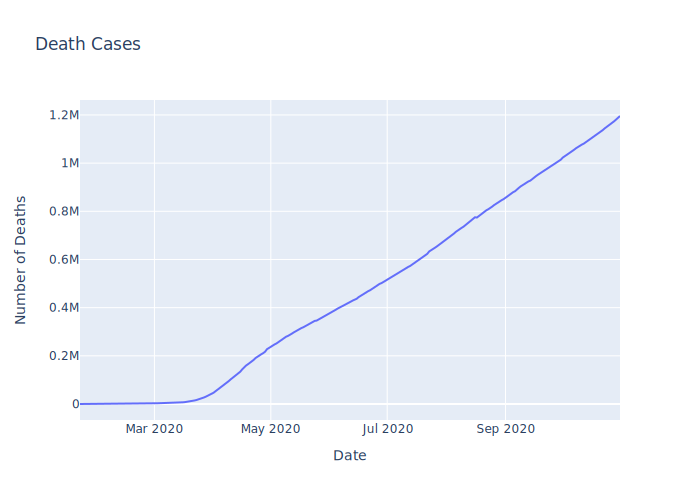

In [233]:
# Time Series visualizing the training data(deaths)

fig = go.Figure()

fig.add_trace(go.Scatter(x=model_train.index, y=model_train['Deaths'],
                         mode = 'lines', name = 'Death Cases'))
fig.update_layout(title='Death Cases',
                  xaxis_title='Date', yaxis_title='Number of Deaths', legend = dict(x=0,y=1, traceorder='normal'))
fig.show(renderer='svg')

In [235]:
#Training the ARIMA Model

model_arima_deaths = auto_arima(model_train['Deaths'], trace = True, error_action='ignore',start_p=0,start_q=0,
                                max_p=5,max_q=5,suppress_warnings=True, stepwise=False,seasonal=False)

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=4886.909, Time=0.14 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=4837.034, Time=0.20 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=4816.258, Time=0.15 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=4808.829, Time=0.32 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=4773.153, Time=0.37 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=4768.934, Time=0.51 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=4871.080, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=4815.559, Time=0.17 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=4816.107, Time=0.19 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=4802.277, Time=0.23 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=4766.072, Time=0.41 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=4870.660, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=4813.497, Time=0.15 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=4733.398, Time=0.56 sec
 ARIMA(3,2,0)(0

In [236]:
#Making predictions based on the ARIMA Model

predictions_deaths_arima = model_arima_deaths.predict(len(model_test))
y_pred['ARIMA Death Prediction'] = predictions_deaths_arima

In [238]:
#Calculating the RMSE

model_death_scores =[]
model_death_scores.append(np.sqrt(mean_squared_error(y_pred['Deaths'], y_pred['ARIMA Death Prediction'])))
print('Root Mean Square for deaths(ARIMA Model): ', np.sqrt(mean_squared_error(model_test['Deaths'], predictions_deaths_arima)))

Root Mean Square for deaths(ARIMA Model):  7046.339988308691


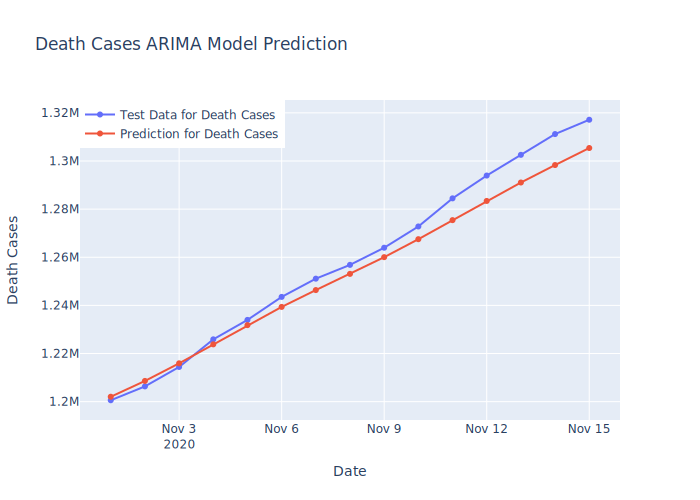

In [240]:
#Performace on test data

fig =go.Figure()
fig.add_trace(go.Scatter(x=model_test.index,y=model_test['Deaths'],
                         mode ='lines + markers', name = 'Test Data for Death Cases'))
fig.add_trace(go.Scatter(x=model_test.index, y= y_pred['ARIMA Death Prediction'],
                         mode = 'lines + markers', name = 'Prediction for Death Cases'))
fig.update_layout(title ='Death Cases ARIMA Model Prediction',
                  xaxis_title='Date', yaxis_title='Death Cases', legend = dict(x=0,y=1,traceorder='normal'))
fig.show(renderer='svg')

## SARIMA Model

In [241]:
#Training the SARIMA Model

model_sarima_deaths = auto_arima(model_train['Deaths'], trace=True,error_action='ignore',
                                 start_p =0, start_q=0,max_p=2,max_q=2, m=7,
                                 suppress_warnings= True, stepwise=True,seasonal=True)
model_sarima_deaths.fit(model_train['Deaths'])

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=4825.002, Time=0.30 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=4884.994, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=4814.716, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=4794.789, Time=0.17 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=4836.811, Time=0.07 sec
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=4711.704, Time=0.45 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=4754.920, Time=0.19 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=4718.949, Time=0.65 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=4713.038, Time=0.70 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=4740.018, Time=0.30 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=4724.652, Time=0.27 sec
 ARIMA(0,2,1)(2,0,2)[7]             : AIC=inf, Time=1.37 sec
 ARIMA(1,2,1)(1,0,1)[7]             : AIC=4713.704, Time=0.47 sec
 ARIMA(0,2,2)(1,0,1)[7]             : AIC=4713.704, Time=0.65 sec
 ARIMA(1,2,0)(1,0,1)[7]             : 

ARIMA(order=(1, 2, 2), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True, with_intercept=False)

In [242]:
#Getting the Predictions from the SARIMA Model

predictions_deaths_sarima =model_sarima_deaths.predict(len(model_test))
y_pred['SARIMA Death Prediction'] = predictions_deaths_sarima

In [245]:
#Calculating the RMSE for the Model
model_death_scores.append(np.sqrt(mean_squared_error(model_test['Deaths'],predictions_deaths_sarima)))
print('Root Mean Square for the SARIMA Model:',np.sqrt(mean_squared_error(model_test['Deaths'], predictions_deaths_sarima)))

Root Mean Square for the SARIMA Model: 7060.457996734976


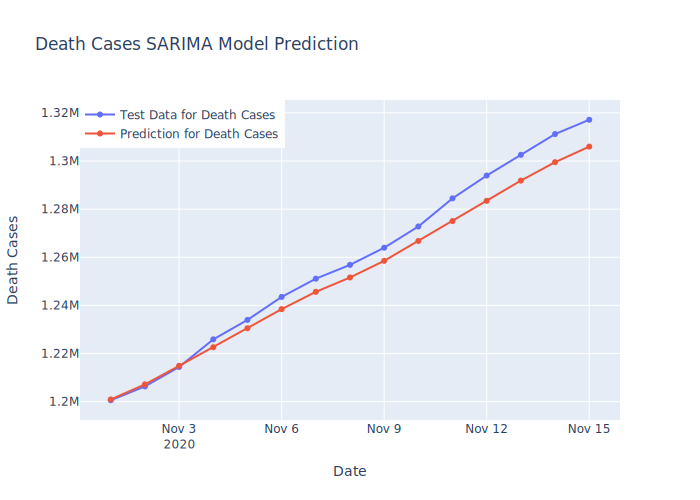

In [247]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_test.index, y=model_test['Deaths'],
              mode = 'lines + markers', name = 'Test Data for Death Cases'))
fig.add_trace(go.Scatter(x=model_test.index, y=y_pred['SARIMA Death Prediction'],
              mode = 'lines + markers', name = 'Prediction for Death Cases'))
fig.update_layout(title = 'Death Cases SARIMA Model Prediction',
                  xaxis_title = 'Date', yaxis_title='Death Cases', legend = dict(x=0,y=1, traceorder='normal'))
fig.show(renderer='svg')

### Comparing the models regarding their death predictions

In [249]:
death_forecast_arima =[]
death_forecast_sarima=[]

for i in range(1,18):
    death_forecast_arima.append(model_arima_deaths.predict(len(model_test) + i)[-1])
    death_forecast_sarima.append(model_sarima_deaths.predict(len(model_test)  + i)[-1])
    
    

model_death_predictions = pd.DataFrame(zip(holt_new_date), columns=['Dates'])
model_death_predictions['ARIMA Model Prediction'] = death_forecast_arima
model_death_predictions['SARIMA Model Prediction'] = death_forecast_sarima
model_death_predictions.head()

,Dates,ARIMA Model Prediction,SARIMA Model Prediction
0,2020-11-16,1312639.88848,1313331.52712
1,2020-11-17,1320278.80498,1321986.99946
2,2020-11-18,1328242.57673,1330649.85237
3,2020-11-19,1336253.02823,1339426.40525
4,2020-11-20,1344040.10521,1348207.62574


## Comparing the RMSE for both of the models


In [251]:
model_names = ['ARIMA Model Death Predictions', 'SARIMA Model Death Predictions']

In [ ]:
death_summary=pd.DataFrame(zip(model_names, model_death_scores), columns=['Model Name','Root Mean Squared Error'])


In [254]:
death_summary

,Model Name,Root Mean Squared Error
0,ARIMA Model Death Predictions,7046.33999
1,SARIMA Model Death Predictions,7060.45800


## Best Model &#8594; <span style="color:red"> ARIMA </span> (for predicting Deaths)

-  giving us the lowest RMSE between the two (even though by a small margin)


## **Conclusion**  &#8594; 
### In this COVID-19 time series analysis, the SARIMA model emerges as the optimal choice for forecasting confirmed cases, showcasing its robust predictive capabilities. Conversely, the ARIMA model excels in accurately predicting deaths. These models offer valuable tools for understanding and navigating the ongoing pandemic dynamics. Continuous refinement and adaptation of these models will contribute to more effective decision-making in the face of the ever-evolving COVID-19 landscape. Feel free to explore the code and contribute to enhancing these forecasting techniques.